# Marelle Board import
* Getting players info dict => `MarelleBoard.players`
* 3 phases : place, move and end => `MarelleBoard.phase`
* Reset the board => `MarelleBoard.initialize_game()`
* Printing the board => `MarelleBoard.print_board()`
* Id:Action dict => `MarelleBoard.action_list_by_id`
* Action:Id dict => `MarelleBoard.action_id_by_action`
* Get the board state => `MarelleBoard.get_state()`
* Play an action => `MarelleBoard.play_action(action_id, player)`
* Get legal action ids => `MarelleBoard.get_legal_action_ids(player)`
* Check if game ended (returns 0 if not ended or winning player id) : `MarelleBoard.check_if_end()`

In [2]:
from maRL_board import MarelleBoard

In [3]:
board = MarelleBoard()
board.initialize_game()#initialize game, reset board, when creat new board reset is automatic
board.phase

board.get_state()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [4]:
board=MarelleBoard()
board.print_board()
a=board.get_legal_action_ids(1)[0]
board.play_action(a,1)
board.print_board()
b=board.get_legal_action_ids(-1)[2]
print(board.action_list_by_id[b])
board.play_action(b,-1)
board.print_board()


        Phase : place
        Placed tokens : P1 : 0 / P2 : 0 
        Tokens on board : P1 : 0 / P2 : 0 
        0--------------0--------------0
        |              |              |
        |    0---------0---------0    |
        |    |         |         |    |
        |    |    0----0----0    |    |
        |    |    |         |    |    |
        0----0----0         0----0----0                 
        |    |    |         |    |    |
        |    |    0----0----0    |    |
        |    |         |         |    |
        |    0---------0---------0    |
        |              |              |
        0--------------0--------------0
        

        Phase : place
        Placed tokens : P1 : 1 / P2 : 0 
        Tokens on board : P1 : 1 / P2 : 0 
        0--------------0--------------0
        |              |              |
        |    0---------0---------0    |
        |    |         |         |    |
        |    |    0----0----0    |    |
        |    |    |         |    |    |


In [5]:
board=MarelleBoard()
board.play_action(board.action_id_by_action[((0,3),None)],1)
board.play_action(board.action_id_by_action[((0,4),None)],-1)
board.play_action(board.action_id_by_action[((1,2),None)],1)
board.play_action(board.action_id_by_action[((1,3),None)],1)
board.play_action(board.action_id_by_action[((1,0),None)],1)

board.phase="move"
board.play_action(board.action_id_by_action[(((1,0),(1,1)),(0,4))],1)

#board.play_action(board.action_id_by_action[((1,1),(0,4))],1)
board.print_board()



        Phase : end
        Placed tokens : P1 : 4 / P2 : 1 
        Tokens on board : P1 : 4 / P2 : 0 
        0--------------0--------------0
        |              |              |
        |    1---------1---------1    |
        |    |         |         |    |
        |    |    1----0----0    |    |
        |    |    |         |    |    |
        0----0----0         0----0----0                 
        |    |    |         |    |    |
        |    |    0----0----0    |    |
        |    |         |         |    |
        |    0---------0---------0    |
        |              |              |
        0--------------0--------------0
        


In [6]:
import gym
from gym import spaces


class MarelleGymEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}
    def __init__(self):
        super(MarelleGymEnv, self).__init__()    
    
    # Define action and observation space
    # They must be gym.spaces objects
        self.board = MarelleBoard()
        self.action_space = spaces.Discrete(len(self.board.action_list_by_id))    # Example for using image as input:
        self.observation_space = spaces.Discrete(len(self.board.get_state()))
        self.list_move = []
        self.current_player = 1
        
    def step(self, action): 
   
        self.board.play_action(action,self.current_player)

        observation=self.board.get_state()
        done = self.board.check_if_end() != 0
        reward = self.board.check_if_end() 
        self.list_move.append(action)
        info = ""
        self.current_player = self.board.get_opponent(self.current_player)

        return observation, reward, done, info
    
    # Execute one time step within the environment
  
    def reset(self):
        self.current_player = 1
        self.list_move = []
        self.board.initialize_game()

        return self.board.get_state()
    # Reset

    def render(self, mode='human', close=False):
        self.board.print_board()



In [7]:

class MarelleGymEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}
    def __init__(self):
        super(MarelleGymEnv, self).__init__()    
    
    # Define action and observation space
    # They must be gym.spaces objects
        self.board = MarelleBoard()
        self.action_space = spaces.Discrete(len(self.board.action_list_by_id))    # Example for using image as input:
        self.observation_space = spaces.Discrete(len(self.board.get_state()))
        self.list_move = []
        self.current_player = 1
        
    def step(self, action): 
   
        self.board.play_action(action,self.current_player)

        observation=self.board.get_state()
        done = self.board.check_if_end() != 0
        reward = self.board.check_if_end() 
        self.list_move.append(action)
        info = ""
        self.current_player = self.board.get_opponent(self.current_player)

        return observation, reward, done, info
    
    # Execute one time step within the environment
  
    def reset(self):
        self.current_player = 1
        self.list_move = []
        self.board.initialize_game()

        return self.board.get_state()
    # Reset

    def render(self, mode='human', close=False):
        self.board.print_board()



### Création d'une classse générale agent dont nos agents seront hérités

In [13]:
class Agent(object):
    def __init__(self, board, player_id, epsilon=0):
        self.epsilon = epsilon
        self.board = board
        self.n_action = len(self.board.action_list_by_id)
        self.player_id = player_id
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

### Notre premier enfant

In [14]:
class RandomAgent(Agent):
    def __init__(self,board, player_id):
        super(RandomAgent, self).__init__(board, player_id)
        pass

    def learned_act(self, s):
        return(np.random.choice(self.board.get_legal_action_ids(self.player_id)))


### Jouons

* Getting players info dict => `MarelleBoard.players`
* 3 phases : place, move and end => `MarelleBoard.phase`
* Reset the board => `MarelleBoard.initialize_game()`
* Printing the board => `MarelleBoard.print_board()`
* Id:Action dict => `MarelleBoard.action_list_by_id`
* Action:Id dict => `MarelleBoard.action_id_by_action`
* Get the board state => `MarelleBoard.get_state()`
* Play an action => `MarelleBoard.play_action(action_id, player)`
* Get legal action ids => `MarelleBoard.get_legal_action_ids(player)`
* Check if game ended (returns 0 if not ended or winning player id) : `MarelleBoard.check_if_end()`

In [20]:
import progressbar
compteur_partie=0
compteur_piccolo=0
compteur_gabrielle=0

n_partie = 100
n_tour = 500
n_pion_p1 = np.zeros((n_partie,2*n_tour))
n_pion_p2 = np.zeros((n_partie,2*n_tour))
list_n_coup_joue=[]

for j in progressbar.progressbar(range(n_partie)): #(n parties)
    marelle_env = MarelleGymEnv()
    piccolo= RandomAgent(marelle_env.board,1)
    gabrielle = RandomAgent(marelle_env.board,-1)

    compteur_partie+=1
    pion_p1 = np.zeros(2*n_tour)
    pion_p2 = np.zeros(2*n_tour)
    n_coup_joue=0
    for i in range (n_tour):

        s=marelle_env.board.get_state()
        a_p1 = piccolo.act(s,train = False)
        s, reward, done, info = marelle_env.step(a_p1)
        pion_p1[i]=marelle_env.board.players[1]["tokens_on_board"]
        pion_p2[i] = marelle_env.board.players[-1]["tokens_on_board"]
        n_coup_joue+=1
        if done:
            #print('Piccolo win fatality')
            compteur_piccolo+=1
            list_n_coup_joue.append(n_coup_joue)
            break

        #marelle_env.render()

        a_p2 = gabrielle.act(s,train = False)
        s, reward, done, info = marelle_env.step(a_p2)
        pion_p1[i] = marelle_env.board.players[1]["tokens_on_board"]
        pion_p2[i] = marelle_env.board.players[-1]["tokens_on_board"]
        n_coup_joue+=1
        if done :
            #print('gabrielle win encore..')
            compteur_gabrielle+=1
            list_n_coup_joue.append(n_coup_joue)
            break
    
    n_pion_p1[j]= pion_p1
    n_pion_p2[j]= pion_p2    
        #marelle_env.render()
 

100% (100 of 100) |######################| Elapsed Time: 0:01:09 Time:  0:01:09


100 54 46
84.7
48.896318879850256


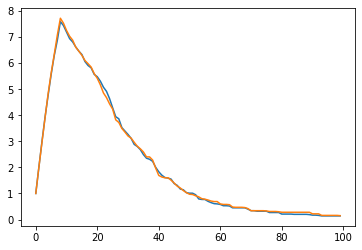

In [29]:
import matplotlib.pyplot as plt
print(compteur_partie, compteur_piccolo, compteur_gabrielle)
print(np.mean(list_n_coup_joue))
print(np.std(list_n_coup_joue))
plt.plot(np.mean(n_pion_p1,axis = 0)[:100])
plt.plot(np.mean(n_pion_p2,axis = 0)[:100])
plt.show()

In [18]:
import cProfile
def boucles(n_partie,n_tour):
    for j in range(n_partie): #(n parties)
        marelle_env = MarelleGymEnv()
        piccolo= RandomAgent(marelle_env.board,1)
        gabrielle = RandomAgent(marelle_env.board,-1)

        for i in range (n_tour):

            s=marelle_env.board.get_state()
            a_p1 = piccolo.act(s,train = False)
            s, reward, done, info = marelle_env.step(a_p1)
            if done:
                #print('Piccolo win fatality')
                break

            a_p2 = gabrielle.act(s,train = False)
            s, reward, done, info = marelle_env.step(a_p2)
            if done :
                #print('gabrielle win encore..')
                break 
        

In [19]:
cProfile.run("boucles(100,130)")

         471080012 function calls (384196460 primitive calls) in 132.630 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      200    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(concatenate)
     7255    0.005    0.000   66.159    0.009 <ipython-input-13-c9cd4e13515a>:11(act)
      200    0.000    0.000    0.000    0.000 <ipython-input-13-c9cd4e13515a>:2(__init__)
      200    0.000    0.000    0.000    0.000 <ipython-input-14-18967b4e80bd>:2(__init__)
     7255    0.020    0.000   66.154    0.009 <ipython-input-14-18967b4e80bd>:6(learned_act)
        1    0.024    0.024  132.630  132.630 <ipython-input-18-230384b5c51d>:2(boucles)
     7255    0.028    0.000   66.194    0.009 <ipython-input-7-abcc0e7cf1ff>:15(step)
      100    0.001    0.000    0.140    0.001 <ipython-input-7-abcc0e7cf1ff>:4(__init__)
        1    0.000    0.000  132.630  132.630 <string>:1(<module>)
      200    0.000    0.000    0.0